In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

from skimage.feature import hog
from sklearn.cluster import KMeans

os.makedirs('results', exist_ok=True)

### OpenCV Transformations:

We will look into following transformations:
1. **Image Transformations:**
    1. **Image Scaling:** Scale image in horizontal or vertical direction
    2. **Image Rotation:** Rotate image by certain angle 
    3. **Image Flipping:**
        1. Horizontal Flip 
        2. Vertical Flip 
    4. **RGB Transformations:**
        1. Converting RGB image to GreyScale Image
        2. Converting RGB image to BGR image
2. **Video Operations:**
    1. Calculating number of frames
    2. Calculating FPS

### Image Transformations

There are two steps in transforming an image: 
1. Transformation of coordinate mesh i.e. arrangement of pixels
2. Remapping pixel intensities using interpolation methods 

Whenever we are doing shape transformation of image, we are mainly concerned with mapping. Mapping can be:
1. Linear: 
    1. Scaling
    2. Flipping
2. Non-Linear: 
    1. Rotation

### Image Scaling

In [2]:
def scale_image(img, scale_factor_width, scale_factor_height):
    h, w, _ = img.shape

    w_new = int(w * scale_factor_width)
    h_new = int(h * scale_factor_height)    
    map_x = np.zeros((h_new, w_new), np.float32)
    map_y = np.zeros((h_new, w_new), np.float32)

    for y in range(1, h_new):
        for x in range(1, w_new):
            xS = x * 1/scale_factor_width
            yS = y * 1/scale_factor_height
            map_x[y, x] = int(xS)
            map_y[y, x] = int(yS)

    result = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return result

In [3]:
path = 'sample.jpg'
img = cv2.imread(path)
h, w, c = img.shape

scale_factor_width = 0.5
scale_factor_height = 1
result = scale_image(img, scale_factor_width, scale_factor_height)
assert result.shape == (int(h * scale_factor_height), int(w * scale_factor_width), c)
cv2.imwrite('results/scaled.jpg', result)

True

### Image Rotation

In [4]:
def get_rotation_matrix(theta):
    M = np.array([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    return M
 
def rotate_image(img, theta, center = None):
    h, w, _ = img.shape

    if center is None:
        Cx, Cy = w / 2, h / 2
    else:
        Cx, Cy = center

    M = get_rotation_matrix(theta)

    map_x = np.zeros((h, w), np.float32)
    map_y = np.zeros((h, w), np.float32)

    for y in range(1, h):
        for x in range(1, w):
            # changing origin to center
            xc = x-Cx
            yc = y-Cy

            # rotating about center
            xc_new, yc_new = M @ np.array([xc, yc])
            
            # changing origin back to top left corner
            xc_new += Cx
            yc_new += Cy
            
            map_x[y, x] = int(xc_new)
            map_y[y, x] = int(yc_new)  
        
    result = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)        
    return result

In [5]:
path = 'sample.jpg'
img = cv2.imread(path)

# angle in radians in clockwise direction
theta = np.pi / 2
result = rotate_image(img, theta, center = None)
cv2.imwrite('results/rotated.jpg', result)

True

### Image Flipping

In [6]:
def flip_image(img, flip):
    h, w, _ = img.shape
    
    map_x = np.zeros((h, w), np.float32)
    map_y = np.zeros((h, w), np.float32)

    for y in range(1, h):
        for x in range(1, w):
            if flip == 1:
                # vertical flip
                xS = x
                yS = h - y
            else:
                # horizontal flip
                xS = w - x
                yS = y

            map_x[y, x] = int(xS)
            map_y[y, x] = int(yS)

    result = cv2.remap(img, map_x, map_y, cv2.INTER_LINEAR)
    return result

In [7]:
path = 'sample.jpg'
img = cv2.imread(path)

# vertical flip
flip = 1
result = flip_image(img, flip)
cv2.imwrite('results/vertical_flip.jpg', result)

# horizontal flip
flip = 0
result = flip_image(img, flip)
cv2.imwrite('results/horizontal_flip.jpg', result)

True

### Convert Image to Grayscale

Grayscale image is when R, G, B pixels are weighted in equal proportion.

In [8]:
def convert_grayscale(img):
    return np.mean(img, axis=2)

img_gray = convert_grayscale(img)
cv2.imwrite('results/grayscale.jpg', img_gray)

True

### Get individual channels of image

In [9]:
def get_individual_channels(img, channel):
    # channels among R/G/B
    if channel=='R':
        # blue channel
        img[:,:,[0,1]] = 0
    elif channel=='G':
        # green channel
        img[:,:,[0,2]] = 0
    else:
        # red channel
        img[:,:,[1,2]] = 0
    return img

img = cv2.imread('sample.jpg')
img = get_individual_channels(img, 'B')
cv2.imwrite('results/channel.jpg', img)

True

### Convert RGB image to BGR image

OpenCV reads the image in BGR format and while writing it saves in RGB format. The BGR ordering can be noticed while plotting using Matplotlib. In order to convert RGB image to BGR image, we need to swap the 1st and 3rd channels of read image and save it, because OpenCV will again shift channels while saving the image.

In [10]:
def RGB_to_BGR(img):
    img = np.stack((img[:,:,2], img[:,:,1], img[:,:,0]))
    return np.moveaxis(img, 0, -1)

img = cv2.imread('sample.jpg')
img = RGB_to_BGR(img)
cv2.imwrite('results/BGR.jpg', img)

True

### Color Quantization using KMeans Clustering

Quantization refers to using low-precision datatypes to reduce memory usage and improving inference runtime. Color quantization refers to bucketing different colors with similar pixel intensities into groups (clusters) and assigning the same intensity to the bucket. This helps in reducing the image storage size as you wouldn't have to store the whole matrix of pixel intensities but a simple index having intensities one per group. 

Naturally, this has vast applications in image compression too. However, Quantization is lossy compression technique.

In [13]:
def color_quantization(img, n_clusters):
    h,w,c = img.shape

    # normalizing 
    # KMeans is distance-based clustering algorithm
    img = img / 255
    
    # flattening pixels
    img = img.reshape(-1, 3)    

    # clustering pixel intensities
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit(img)
    labels = clusters.labels_
    centers = clusters.cluster_centers_

    new_img = list(map(lambda label: centers[label], labels))
    new_img = np.array(new_img)
    new_img = new_img.reshape(h,w,c)

    # post-processing
    new_img = new_img * 255
    new_img = new_img.astype('uint8')
    new_img = np.clip(new_img, 0, 255)
    return new_img 

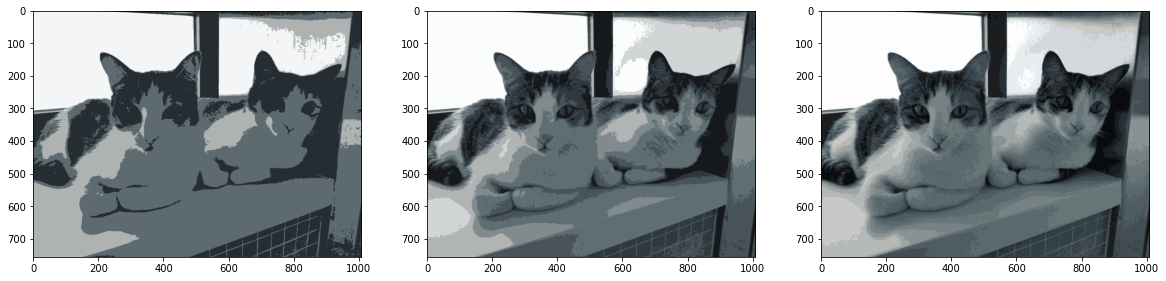

In [14]:
plt.figure(figsize=(20,5))
img = cv2.imread('sample.jpg')

plt.subplot(131)
new_img = color_quantization(img, n_clusters=4)
plt.imshow(new_img)

plt.subplot(132)
new_img = color_quantization(img, n_clusters=8)
plt.imshow(new_img)

plt.subplot(133)
new_img = color_quantization(img, n_clusters=16)
plt.imshow(new_img)
plt.show()

### Image Segmentation using KMeans Clustering

A very naive approach of segmenting pixels in image will be based on pixel intensities. However, this will work when there is sharp contrast between intensities and are well-defined.

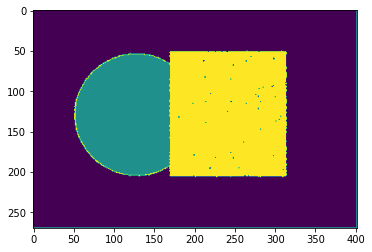

In [37]:
img = cv2.imread('shapes.png')
h,w,c = img.shape

img = img / 255
img = img.reshape(-1, 3)

# clustering
kmeans = KMeans(n_clusters=3)
clusters = kmeans.fit(img)
labels = clusters.labels_

# segmentation mask
mask = labels.reshape(h,w,1)
mask = mask.astype('uint8')

plt.imshow(mask)
plt.show()

### Video Operations

#### Calculating number of frames

In [ ]:
def count_num_frames(vid):
    count = 0
    ret_val = True
    while ret_val:
        ret_val, frame = vid.read()
        count += 1
    return count

# vid = cv2.VideoCapture('sample.mp4')
# num_frames = count_num_frames(vid)
# num_frames

#### Calculating FPS

In [ ]:
def webcam_fps(vid, num_frames):
    start = time.time()
    for _ in range(num_frames):
        vid.read()
    end = time.time()
    return num_frames / (end - start)

# vid = cv2.VideoCapture('sample.mp4')
# webcam_fps(vid, num_frames)

### Important Points:

1. Pixels values are uint8 i.e. unsigned integers with 8 bits. Hence, they range in [0,255], with 255 representing white while 0 representing black.
2. Number of bytes occupied by the image will be (height * width * channels * 8) bits
3. Adding constant to image implies increasing brightness of image, subtracting constant implies darkening the image
4. If you subtract a larger number from pixel value such that pixel value goes negative, for example - subtracting **1000** from **uint8** type pixel value **254**, making it **-746**, in that case, the **2's complement** value will be assigned i.e. **2^N - 746**, where N is number of bits of new pixel data type. 
5. Adding constant like:
    1. **img+=1000**, will modify the existing data type in place i.e. **uint8** 
    2. **img = img + 1000**, will assign a new data type **uint16**

### Image Processing

We will look at following operations:
1. Making a black image
2. Making a white image
3. Brightening an image
4. Darkening an image
5. Subtracting constant from image
6. Subtracting mean channelwise from image
7. Adding noise to image
8. Getting HOG features

In [ ]:
img_size = 64
img_black = np.zeros(shape=(img_size, img_size)).astype('uint8')
img_white = np.ones(shape=(img_size, img_size)).astype('uint8') * 255
img_brighten = img_black + 150
img_darken = img_white - 150

cv2.imwrite('results/black.png', img_black)
cv2.imwrite('results/white.png', img_white)
cv2.imwrite('results/brighten.png', img_brighten)
cv2.imwrite('results/darken.png', img_darken)

True

In [ ]:
img = cv2.imread('sample.jpg')
# modifying original image
img -= 1000

# pure white image
img = img - 10000
cv2.imwrite('results/subtracting_constant.jpg', img)

True

In [ ]:
img = cv2.imread('sample.jpg')
h,w,c = img.shape

mu = np.mean(np.mean(img, axis=0), axis=0)
c1 = np.ones((h,w)) * mu[0]
c2 = np.ones((h,w)) * mu[1]
c3 = np.ones((h,w)) * mu[2]

mu = np.dstack((c1, c2, c3)).astype('uint8')
img -= mu
cv2.imwrite('results/mean_subtracted.png', img)

True

#### Adding Noise to image

Noise can of different types: Gaussian, Poisson etc. We will be adding standard gaussian noise to the image.

In order to add noise appropriately, following are the steps:
1. Normalize the image 
    1. Shift-wise centering 
    2. Scale-wise centering  
2. Adding noise: Since image and noise both are float64 dtypes, modify the image by adding noise
3. Inverse normalizing (shift and scale)
4. Clipping the image pixel values to [0, 255]
5. Converting the datatype to **uint8**

In [ ]:
img = cv2.imread('sample.jpg')
mu = np.mean(img)
sigma = np.std(img)

# centering and scaling
img = (img - mu) / sigma

# adding noise
noise = np.random.normal(0,1,img.shape)

# both float64 dtypes
img += noise
img = img * sigma + mu
img = np.clip(img, 0, 255)
img = img.astype('uint8')
cv2.imwrite('results/add_noise.png', img)

True

#### Getting HOG Features

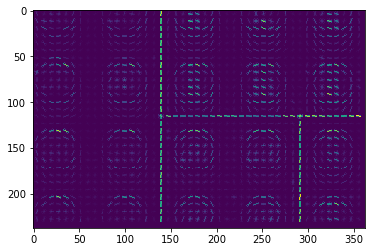

In [ ]:
img = cv2.imread('lego.png')
fd, hog_image = hog(img, orientations=8, pixels_per_cell=(8,8), cells_per_block=(1,1), visualize=True, multichannel=True)
cv2.imwrite('results/hog_image.png', hog_image)

plt.imshow(hog_image)
plt.show()